In [151]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")


In [2]:
df = pd.read_json('json_archive/model_5_df.json')
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])

In [3]:
df = df.sort_values(by='Date/Time (PST)',ascending=True)

In [4]:
ddf = df.drop_duplicates(subset='Date/Time (PST)').copy()
ddf['id'] = ddf.index
ddf['Date'] = ddf['Date/Time (PST)']
ddf.index = ddf['Date/Time (PST)']
ddf = ddf.drop('Date/Time (PST)', axis=1)



In [5]:
ddf['24 Hour Snow (in)'].astype(float)

Date/Time (PST)
2015-12-04 00:00:00    2.499
2015-12-04 01:00:00    2.701
2015-12-04 02:00:00    2.295
2015-12-04 03:00:00    2.566
2015-12-04 04:00:00    1.756
2015-12-04 05:00:00    0.275
2015-12-04 06:00:00    0.141
2015-12-04 07:00:00    0.409
2015-12-04 08:00:00    0.947
2015-12-04 09:00:00    1.081
2015-12-04 10:00:00    1.083
2015-12-04 11:00:00    0.952
2015-12-04 12:00:00    1.626
2015-12-04 13:00:00    1.761
2015-12-04 14:00:00    1.759
2015-12-04 15:00:00    1.081
2015-12-04 16:00:00    1.887
2015-12-04 17:00:00    1.954
2015-12-04 18:00:00    2.290
2015-12-04 19:00:00    2.491
2015-12-04 20:00:00    2.555
2015-12-04 21:00:00    2.692
2015-12-04 22:00:00    2.558
2015-12-04 23:00:00    2.692
2015-12-05 00:00:00    2.678
2015-12-05 01:00:00    2.678
2015-12-05 02:00:00    2.477
2015-12-05 03:00:00    2.544
2015-12-05 04:00:00    2.544
2015-12-05 05:00:00    0.192
                       ...  
2019-04-12 18:00:00    0.370
2019-04-12 19:00:00    0.373
2019-04-12 20:00:00    0.36

In [6]:
ddf.loc[ddf["Date"] == '2015-12-04 01:00:00',"Date"]

Date/Time (PST)
2015-12-04 01:00:00   2015-12-04 01:00:00
Name: Date, dtype: datetime64[ns]

In [7]:
df.loc[df["Date/Time (PST)"] == '2015-12-04 01:00:00','Date/Time (PST)']

1   2015-12-04 01:00:00
Name: Date/Time (PST), dtype: datetime64[ns]

In [8]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12619 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 26 columns):
Battery Voltage (v)         12619 non-null float64
Temperature (deg F)         12619 non-null float64
Wind Speed Minimum (mph)    12619 non-null float64
Wind Speed Average (mph)    12619 non-null float64
Wind Speed Maximum (mph)    12619 non-null float64
Wind Direction (deg.)       12619 non-null float64
date                        12619 non-null datetime64[ns]
24 Hour Snow (in)           12619 non-null float64
Total Snow Depth (in)       12619 non-null float64
area                        12619 non-null object
danger_above_treeline       12619 non-null int64
danger_below_treeline       12619 non-null int64
danger_near_treeline        12619 non-null int64
date_tomorrow               12619 non-null object
month                       12619 non-null int64
max_1_day_temp              12619 non-null float64
min_1_day_temp              12619 non-null 

In [9]:
# def get_previous_day_snow_kv(df, dt):
#     target_hour = dt - pd.Timedelta('1 day')
#     if target_hour in df.Date:
#         return df.loc[target_hour,'24 Hour Snow (in)']
#     else:
#         return None

In [10]:
import pdb

In [11]:
def get_previous_day_snow(df, dt):
    target_hour = dt - pd.Timedelta('24 hours')
    #target_hour_list=[]
    if target_hour in df.index:
        snow = df.loc[target_hour, '24 Hour Snow (in)']
        if type(snow) is not np.float64:
            pdb.set_trace()
        return snow
    else:
        return np.nan
    #return target_hour_list

In [12]:
ddf['Prev Day 24 Hour Snow (in)'] = [get_previous_day_snow(ddf, dt) for dt in ddf.index]


In [13]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12619 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 27 columns):
Battery Voltage (v)           12619 non-null float64
Temperature (deg F)           12619 non-null float64
Wind Speed Minimum (mph)      12619 non-null float64
Wind Speed Average (mph)      12619 non-null float64
Wind Speed Maximum (mph)      12619 non-null float64
Wind Direction (deg.)         12619 non-null float64
date                          12619 non-null datetime64[ns]
24 Hour Snow (in)             12619 non-null float64
Total Snow Depth (in)         12619 non-null float64
area                          12619 non-null object
danger_above_treeline         12619 non-null int64
danger_below_treeline         12619 non-null int64
danger_near_treeline          12619 non-null int64
date_tomorrow                 12619 non-null object
month                         12619 non-null int64
max_1_day_temp                12619 non-null float64
min_1_day_t

In [14]:
ddf.isna().sum()

Battery Voltage (v)             0
Temperature (deg F)             0
Wind Speed Minimum (mph)        0
Wind Speed Average (mph)        0
Wind Speed Maximum (mph)        0
Wind Direction (deg.)           0
date                            0
24 Hour Snow (in)               0
Total Snow Depth (in)           0
area                            0
danger_above_treeline           0
danger_below_treeline           0
danger_near_treeline            0
date_tomorrow                   0
month                           0
max_1_day_temp                  0
min_1_day_temp                  0
max_2_day_temp                  0
min_2_day_temp                  0
max_1_day_wind                  0
max_2_day_wind                  0
max_1_day_snow                  0
max_2_day_snow                  0
max_3_day_snow                  0
id                              0
Date                            0
Prev Day 24 Hour Snow (in)    385
dtype: int64

In [15]:
ddf[['Prev Day 24 Hour Snow (in)']]

,Prev Day 24 Hour Snow (in)
Date/Time (PST),
2015-12-04 00:00:00,NaN
2015-12-04 01:00:00,NaN
2015-12-04 02:00:00,NaN
2015-12-04 03:00:00,NaN
2015-12-04 04:00:00,NaN
2015-12-04 05:00:00,NaN
2015-12-04 06:00:00,NaN
2015-12-04 07:00:00,NaN
2015-12-04 08:00:00,NaN


In [16]:
ddf.tail(50)

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),area,...,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id,Date,Prev Day 24 Hour Snow (in)
Date/Time (PST),,,,,,,,,,,,,,,,,,,,,
2019-04-11 22:00:00,12.62,30.92,0.000,0.000,0.00,0.0,2019-04-11,0.365,96.2,Stevens Pass,...,33.69,26.62,30.320,30.32,11.910,11.910,11.910,15625,2019-04-11 22:00:00,11.300
2019-04-11 23:00:00,12.61,31.22,0.000,0.000,0.00,0.0,2019-04-11,0.499,96.6,Stevens Pass,...,33.69,26.62,30.320,30.32,11.640,11.910,11.910,15626,2019-04-11 23:00:00,11.910
2019-04-12 00:00:00,12.59,31.03,0.000,0.000,0.00,0.0,2019-04-12,0.231,96.3,Stevens Pass,...,33.69,26.62,24.200,30.32,11.640,11.910,11.910,15627,2019-04-12 00:00:00,11.640
2019-04-12 01:00:00,12.55,30.78,0.000,0.000,0.00,0.0,2019-04-12,0.230,95.3,Stevens Pass,...,33.69,26.62,17.580,30.32,0.499,11.910,11.910,15630,2019-04-12 01:00:00,10.500
2019-04-12 02:00:00,12.57,30.52,0.000,0.000,0.00,0.0,2019-04-12,0.499,98.1,Stevens Pass,...,33.69,26.62,9.600,30.32,0.499,11.910,11.910,15634,2019-04-12 02:00:00,11.500
2019-04-12 03:00:00,13.52,30.30,0.000,0.000,0.00,0.0,2019-04-12,0.499,98.5,Stevens Pass,...,33.69,26.62,8.880,30.32,0.499,11.910,11.910,15638,2019-04-12 03:00:00,11.640
2019-04-12 04:00:00,13.51,30.28,0.000,0.000,0.00,0.0,2019-04-12,0.499,98.3,Stevens Pass,...,33.69,26.62,8.880,30.32,0.499,11.910,11.910,15641,2019-04-12 04:00:00,0.351
2019-04-12 05:00:00,12.90,30.13,0.000,0.000,0.00,0.0,2019-04-12,0.365,96.4,Stevens Pass,...,33.69,26.62,7.014,30.32,0.499,11.910,11.910,15644,2019-04-12 05:00:00,0.350
2019-04-12 06:00:00,12.81,30.09,0.000,0.000,0.00,0.0,2019-04-12,0.230,96.5,Stevens Pass,...,33.69,26.62,7.014,30.32,0.499,11.910,11.910,15645,2019-04-12 06:00:00,0.349


In [17]:
ddf.shape , df.shape

((12619, 27), (15723, 25))

In [20]:
ddf.isna().sum()

Battery Voltage (v)             0
Temperature (deg F)             0
Wind Speed Minimum (mph)        0
Wind Speed Average (mph)        0
Wind Speed Maximum (mph)        0
Wind Direction (deg.)           0
date                            0
24 Hour Snow (in)               0
Total Snow Depth (in)           0
area                            0
danger_above_treeline           0
danger_below_treeline           0
danger_near_treeline            0
date_tomorrow                   0
month                           0
max_1_day_temp                  0
min_1_day_temp                  0
max_2_day_temp                  0
min_2_day_temp                  0
max_1_day_wind                  0
max_2_day_wind                  0
max_1_day_snow                  0
max_2_day_snow                  0
max_3_day_snow                  0
id                              0
Date                            0
Prev Day 24 Hour Snow (in)    385
dtype: int64

In [21]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12619 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 27 columns):
Battery Voltage (v)           12619 non-null float64
Temperature (deg F)           12619 non-null float64
Wind Speed Minimum (mph)      12619 non-null float64
Wind Speed Average (mph)      12619 non-null float64
Wind Speed Maximum (mph)      12619 non-null float64
Wind Direction (deg.)         12619 non-null float64
date                          12619 non-null datetime64[ns]
24 Hour Snow (in)             12619 non-null float64
Total Snow Depth (in)         12619 non-null float64
area                          12619 non-null object
danger_above_treeline         12619 non-null int64
danger_below_treeline         12619 non-null int64
danger_near_treeline          12619 non-null int64
date_tomorrow                 12619 non-null object
month                         12619 non-null int64
max_1_day_temp                12619 non-null float64
min_1_day_t

In [29]:
ddf_clean = ddf.dropna()

In [30]:
ddf_clean.isna().sum()

Battery Voltage (v)           0
Temperature (deg F)           0
Wind Speed Minimum (mph)      0
Wind Speed Average (mph)      0
Wind Speed Maximum (mph)      0
Wind Direction (deg.)         0
date                          0
24 Hour Snow (in)             0
Total Snow Depth (in)         0
area                          0
danger_above_treeline         0
danger_below_treeline         0
danger_near_treeline          0
date_tomorrow                 0
month                         0
max_1_day_temp                0
min_1_day_temp                0
max_2_day_temp                0
min_2_day_temp                0
max_1_day_wind                0
max_2_day_wind                0
max_1_day_snow                0
max_2_day_snow                0
max_3_day_snow                0
id                            0
Date                          0
Prev Day 24 Hour Snow (in)    0
dtype: int64

In [36]:
ddf_clean.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id,Prev Day 24 Hour Snow (in)
count,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,...,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000
mean,12.711145,25.855567,1.538335,5.844447,12.128924,179.252638,3.534715,93.352098,2.513977,2.022478,...,22.052347,32.851316,20.491720,21.799865,26.179258,13.101950,18.488373,22.442481,8001.095308,3.621057
std,0.221707,8.209162,2.444115,4.815586,8.557333,98.040235,10.434262,27.306879,0.768255,0.763597,...,7.464005,8.708571,7.335738,11.513586,12.340603,18.865449,20.743252,21.288131,4667.488634,10.696897
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,-2.007000,8.440000,-2.007000,0.000000,0.000000,-2.916000,-0.919000,0.386000,24.000000,-12.000000
25%,12.600000,21.000000,0.000000,2.914250,6.971000,86.600000,0.283000,75.222500,2.000000,2.000000,...,18.052500,26.770000,16.590000,13.460000,16.680000,0.614000,1.131000,2.796000,3776.250000,0.285000
50%,12.660000,25.865000,0.132000,4.448000,9.890000,231.050000,0.488000,92.500000,2.000000,2.000000,...,22.790000,32.170000,21.270000,18.410000,23.850000,2.828000,5.649000,10.220000,8045.500000,0.495000
75%,12.730000,30.830000,2.302000,7.291000,14.580000,270.600000,2.164000,114.500000,3.000000,2.000000,...,26.920000,37.870000,25.170000,28.320000,33.490000,14.110000,46.490000,46.490000,12183.750000,2.208000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,46.530000,67.880000,44.570000,71.790000,71.790000,75.000000,75.000000,75.000000,15722.000000,75.000000


In [42]:
ddf_clean.shape[0]*.80

9787.2

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15723 entries, 0 to 15722
Data columns (total 25 columns):
Date/Time (PST)             15723 non-null datetime64[ns]
Battery Voltage (v)         15723 non-null float64
Temperature (deg F)         15723 non-null float64
Wind Speed Minimum (mph)    15723 non-null float64
Wind Speed Average (mph)    15723 non-null float64
Wind Speed Maximum (mph)    15723 non-null float64
Wind Direction (deg.)       15723 non-null float64
date                        15723 non-null datetime64[ns]
24 Hour Snow (in)           15723 non-null float64
Total Snow Depth (in)       15723 non-null float64
area                        15723 non-null object
danger_above_treeline       15723 non-null int64
danger_below_treeline       15723 non-null int64
danger_near_treeline        15723 non-null int64
date_tomorrow               15723 non-null object
month                       15723 non-null int64
max_1_day_temp              15723 non-null float64
min_1_day_temp      

In [44]:
df.isna().sum()

Date/Time (PST)             0
Battery Voltage (v)         0
Temperature (deg F)         0
Wind Speed Minimum (mph)    0
Wind Speed Average (mph)    0
Wind Speed Maximum (mph)    0
Wind Direction (deg.)       0
date                        0
24 Hour Snow (in)           0
Total Snow Depth (in)       0
area                        0
danger_above_treeline       0
danger_below_treeline       0
danger_near_treeline        0
date_tomorrow               0
month                       0
max_1_day_temp              0
min_1_day_temp              0
max_2_day_temp              0
min_2_day_temp              0
max_1_day_wind              0
max_2_day_wind              0
max_1_day_snow              0
max_2_day_snow              0
max_3_day_snow              0
dtype: int64

In [49]:
df['Date/Time (PST)'][1]

Timestamp('2015-12-04 01:00:00')

In [113]:
index_split = df.loc[df['Date/Time (PST)'] == pd.Timestamp('2019-1-01 0:00:00')].index
index_split

Int64Index([12963], dtype='int64')

## To split between 2018 and 2019 for a temporal train/test split, the index is 12963

In [58]:
X = df[[ 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow',
       ]]

y = df['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12963], X[12963:], y[:12963], y[12963:]

In [61]:
ss = StandardScaler()

lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100)
knnr = KNeighborsRegressor()
regressors = [lr, rfr, gbr, knnr ]

reg_names = ['LinearRegression',
             'RandomForestRegressor',
             'GradientBoostingRegressor',
             'KNeighborsRegressor',
            ]

In [62]:
mapper = DataFrameMapper([
    ([  'Temperature (deg F)',
        'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
        'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
        '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
        'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
        'max_1_day_snow',], ss)
    ])

In [63]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        #('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5557355550412715 0.9101123137172801
The MAE of just predicting the mean is: 0.5557355550412715
The RMSE just predicting the mean is: 0.9101123137172801

The MAE of the LinearRegression is: 0.7312745480351275
The RMSE of the LinearRegression is: 0.723430658010083

The MAE of the RandomForestRegressor is: 0.7590910858063031
The RMSE of the RandomForestRegressor is: 0.8122182628862589

The MAE of the GradientBoostingRegressor is: 0.6922276715469805
The RMSE of the GradientBoostingRegressor is: 0.6723734751759102

The MAE of the KNeighborsRegressor is: 0.7717391304347826
The RMSE of the KNeighborsRegressor is: 0.8973623188405798



In [104]:
precip_df= pd.read_csv('csv_files/stevens_pass_precipitation_rain.csv')


precip_df.columns 

precip_df.columns = ['Date/Time (PST)', '2700ft_berne',
       '3950ft_schmidt_haus',
       '4800_brooks']
precip_df['Date/Time (PST)'] = pd.to_datetime(precip_df['Date/Time (PST)'])

In [105]:
precip_df.describe()

,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,40954.000000,41685.000000,31005.000000
mean,0.006208,0.009511,0.008432
std,0.021681,0.030280,0.122046
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.450000,1.900000,21.090000


In [106]:
df_merge = pd.merge(df,precip_df,how='left',on="Date/Time (PST)")

In [107]:
df_merge.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,...,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15719.000000,15717.000000,15719.000000
mean,12.712180,25.686039,1.550468,5.858092,12.168595,180.236988,3.623776,91.814593,2.560071,2.059721,...,32.461220,20.594475,21.320633,25.705096,12.934781,18.338808,22.360921,0.010529,0.015020,0.013452
std,0.222958,8.171398,2.494440,4.907271,8.606101,97.759957,10.680059,28.567430,0.765046,0.768319,...,8.734424,7.375346,11.467187,12.215800,18.980217,20.982391,21.599756,0.026654,0.033478,0.170181
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,6.934000,-2.007000,0.000000,0.000000,-2.916000,-1.043000,0.386000,0.000000,0.000000,0.000000
25%,12.600000,21.080000,0.000000,2.886000,6.992000,86.700000,0.292000,73.445000,2.000000,2.000000,...,26.655000,16.590000,12.650000,15.850000,0.624000,1.215000,2.821000,0.000000,0.000000,0.000000
50%,12.660000,25.780000,0.088000,4.398000,9.890000,238.000000,0.512000,91.800000,3.000000,2.000000,...,31.970000,21.440000,17.930000,23.610000,2.828000,5.380000,9.600000,0.000000,0.000000,0.000000
75%,12.730000,30.490000,2.324000,7.287000,14.530000,270.400000,2.409000,114.000000,3.000000,3.000000,...,37.350000,25.330000,27.790000,32.970000,12.370000,46.490000,46.490000,0.010000,0.010000,0.010000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,68.510000,48.340000,71.790000,71.790000,75.000000,75.000000,75.000000,0.360000,0.370000,21.090000


In [110]:
df_merge.isna().sum()

Date/Time (PST)             0
Battery Voltage (v)         0
Temperature (deg F)         0
Wind Speed Minimum (mph)    0
Wind Speed Average (mph)    0
Wind Speed Maximum (mph)    0
Wind Direction (deg.)       0
date                        0
24 Hour Snow (in)           0
Total Snow Depth (in)       0
area                        0
danger_above_treeline       0
danger_below_treeline       0
danger_near_treeline        0
date_tomorrow               0
month                       0
max_1_day_temp              0
min_1_day_temp              0
max_2_day_temp              0
min_2_day_temp              0
max_1_day_wind              0
max_2_day_wind              0
max_1_day_snow              0
max_2_day_snow              0
max_3_day_snow              0
2700ft_berne                4
3950ft_schmidt_haus         6
4800_brooks                 4
dtype: int64

In [111]:
df_merge_clean = df_merge.dropna()

In [114]:
index_split

Int64Index([12963], dtype='int64')

In [116]:
mapper = DataFrameMapper([
    ([   'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow','max_2_day_snow','max_3_day_snow','4800_brooks'], ss)
    ])

X = df_cleaned[['Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow','max_2_day_snow','max_3_day_snow','4800_brooks']]

y = df_cleaned['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12963], X[12963:], y[:12963], y[12963:]

baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

pipe2 = Pipeline(steps=[
('scaler',mapper),
('regressor', gbr)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
print(f'The MAE of the {name}'
f' is: {mean_absolute_error((y_test),preds)}\n'
f'The RMSE of the regressor is:'
f' is: {mean_squared_error((y_test),preds)}\n'
'==================================================================\n'
'========================\n'
)

0.5564298387718893 0.9083015383164386
The MAE of just predicting the mean is: 0.5564298387718893
The RMSE just predicting the mean is: 0.9083015383164386

The MAE of the LinearRegression is: 0.7266515890739426
The RMSE of the LinearRegression is: 0.7103449119997397

The MAE of the RandomForestRegressor is: 0.6916576235432446
The RMSE of the RandomForestRegressor is: 0.7088143121303848

The MAE of the GradientBoostingRegressor is: 0.6893738020522222
The RMSE of the GradientBoostingRegressor is: 0.6631823290665355

The MAE of the KNeighborsRegressor is: 0.8002178649237474
The RMSE of the KNeighborsRegressor is: 0.9684386347131445

The MAE of the KNeighborsRegressor is: 0.6895496032543603
The RMSE of the regressor is: is: 0.6633198894837533



In [117]:
pipe2 = Pipeline(steps=[
('scaler',mapper),
('regressor', gbr)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
print(f'The MAE of the {name}'
f' is: {mean_absolute_error((y_test),preds)}\n'
f'The RMSE of the regressor is:'
f' is: {mean_squared_error((y_test),preds)}\n'
'==================================================================\n'
'========================\n'
)

The MAE of the KNeighborsRegressor is: 0.6894035008868428
The RMSE of the regressor is: is: 0.6631868092127001



In [118]:
y_predict = list(pipe2.predict(X_test))

In [119]:
len(y_test),len(y_predict)

(2754, 2754)

In [120]:
len(y_predict)

2754

In [121]:
y_predict = np.array(y_predict)

In [122]:
type(y_test),len(y_test)

(pandas.core.series.Series, 2754)

In [123]:
df_y = (pd.DataFrame({'y_true':y_test,'y_predict':y_predict}))

In [175]:
def violin_plot_error(model, X, y_true, rescale=False):
    y_pred = model.predict(X)
    sns.set(font_scale=1.5)
    if rescale:
        y_pred_95 = np.percentile(y_pred, 95)
        y_pred_5 = np.percentile(y_pred, 5)
        scaling_factor = 3 / (y_pred_95 - y_pred_5)
        y_pred -= y_pred_5
        y_pred *= scaling_factor
        y_pred += 1
    df_y = pd.DataFrame({'Human Forecast': y_true, 'Model Prediction': y_pred})
    
    
    fig, axes = plt.subplots(figsize=(7, 7))
    axes.set_ylim([-0.5,5])
    axes.xaxis.set_tick_params(labelsize=20)
    axes.yaxis.set_tick_params(labelsize=20)
    
    #sns.violinplot(x='groups',y='danger level', data=df_violin, ax = axes)
    violin = sns.violinplot(x='Human Forecast',y='Model Prediction', data=df_y, ax=axes).set_title(
        'Danger Level Comparison')
    return violin

In [176]:
y_preds = pipe.predict(X_test)

In [177]:
y_pred_95 = np.percentile(y_preds, 95)
y_pred_5 = np.percentile(y_preds, 5)

In [178]:
scaling_factor = 3 / (y_pred_95 - y_pred_5)

In [179]:
scaling_factor


1.5

In [180]:
y_pred_5

1.2

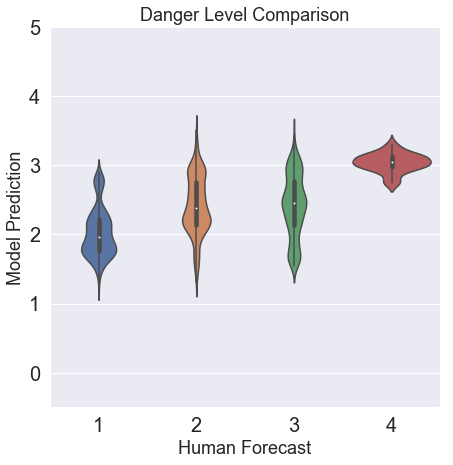

In [181]:
violin_plot_error(pipe2, X_test, y_test);

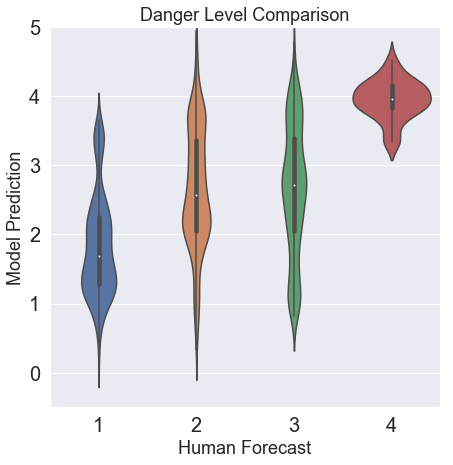

In [182]:
violin_plot_error(pipe2, X_test, y_test, rescale=True);


In [183]:
pipe2.steps

[('scaler', DataFrameMapper(default=False, df_out=False,
                  features=[(['Temperature (deg F)', 'Wind Speed Minimum (mph)',
                              'Wind Speed Average (mph)',
                              'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
                              'Total Snow Depth (in)', 'max_1_day_temp',
                              'min_1_day_temp', 'max_2_day_temp',
                              'min_2_day_temp', 'max_1_day_snow',
                              'max_2_day_snow', 'max_3_day_snow', '4800_brooks'],
                             StandardScaler(copy=True, with_mean=True,
                                            with_std=True))],
                  input_df=False, sparse=False)),
 ('regressor',
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                     

In [189]:
# save the model to disk
filename = 'avy_danger_prediction.pkl'
pickle.dump(pipe2, open(filename, 'wb'))
 

In [192]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [193]:
X_test[1:2]

,Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,4800_brooks
12969,22.04,6.335,10.48,16.37,272.2,77.73,25.39,16.42,25.39,15.53,0.459,2.356,46.76,0.0


In [194]:
X_test.columns

Index(['Temperature (deg F)', 'Wind Speed Minimum (mph)',
       'Wind Speed Average (mph)', 'Wind Speed Maximum (mph)',
       'Wind Direction (deg.)', 'Total Snow Depth (in)', 'max_1_day_temp',
       'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp', 'max_1_day_snow',
       'max_2_day_snow', 'max_3_day_snow', '4800_brooks'],
      dtype='object')

In [195]:
result = loaded_model.predict(X_test[1:2])
print(result)

[1.83839957]
